In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
116.7202, 38.7238, 116.8516, 38.8517

In [3]:
# 定义参数
region = 'tianjin'
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [5]:
## 指数的计算
def water_index(img):
    image = img
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('(B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7)/10000',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# 数据集

In [6]:
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate('2015-01-01','2015-12-31').filter(ee.Filter.lt('CLOUD_COVER',5))
# print(l8.aggregate_array('system:id').getInfo())

# l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate('2005-04-01','2005-10-31').filter(ee.Filter.lt('CLOUD_COVER',10))
# print(l5.aggregate_array('system:id').getInfo())

In [7]:
# dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
#             .filterDate('2020-05-25', '2020-05-28') \
#             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
#             .filterBounds(roi)
# print(dataset.size().getInfo())
# print(dataset.aggregate_array('system:id').getInfo())

# # sentinel-2
# # 加载sentinel 图像
# def maskS2clouds(image):
#     qa = image.select('QA60')
#     cloudBitMask = 1 << 10
#     cirrusBitMask = 1 << 11
#     mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
#              .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
#     return image.updateMask(mask).divide(10000)
# sen1 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TWL')
# sen2 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TWM')
# sen3 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TWN')
# sen4 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TXL')
# sen5 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TXM')
# sen6 = ee.Image('COPERNICUS/S2_SR/20200526T024551_20200526T024552_T51TXN')
# # sen2 = ee.Image('COPERNICUS/S2_SR/20201225T030131_20201225T030129_T50RKU')
# # sen3 = ee.Image('COPERNICUS/S2_SR/20201225T030131_20201225T030129_T50RLU')

# sen14 = ee.ImageCollection([sen1,sen2,sen3,sen4,sen5,sen6])
# Map.addLayer(maskS2clouds(sen14.mosaic().clip(roi)),{'min': 0.0,'max': 0.3,'bands': ['B8', 'B4', 'B3']},'sen14')

In [8]:
#  'LANDSAT/LC08/C01/T1_SR/LC08_122033_20200305', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122033_20200422', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122033_20200828',  
#  'LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_123033_20200904',  
#  'LANDSAT/LC08/C01/T1_SR/LC08_123033_20201022', 
a = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920')
image = maskSR(water_index(a)).clip(roi)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image, visParams,'image')

# k-mean聚类，RF训练

In [9]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

In [10]:
region = 'tianjin'
sample_region = 'TIANJIN'

In [11]:
totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
print(totalSamples.size().getInfo())
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
new_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(new_result.clip(roi).selfMask(),{'palette':['blue']},"new_result") 

19668


In [ ]:
awei = image.select('AWEI').gt(-0.05)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#16d60a']},'awei')

ndwi = image.select('NDWI').gt(-0.1)
Map.addLayer(ndwi.clip(roi).selfMask(),{'palette':['#cad60d']},'ndwi')

mndwi = image.select('mNDWI').gt(-0.07)
Map.addLayer(mndwi.clip(roi).selfMask(),{'palette':['#7960ff']},'mndwi')

In [ ]:
q = new_result.subtract(mndwi)
Map.addLayer(q.clip(roi),{'palette':['red','white','blue']},"q") 

# 制图

In [ ]:
## 建筑物阴影
# 117.2300, 39.0743, 117.1080, 39.1816

# 116.8516, 38.7238, 116.7202, 38.8517

Text(0.5, 1.0, 'Raw image (20200920)')

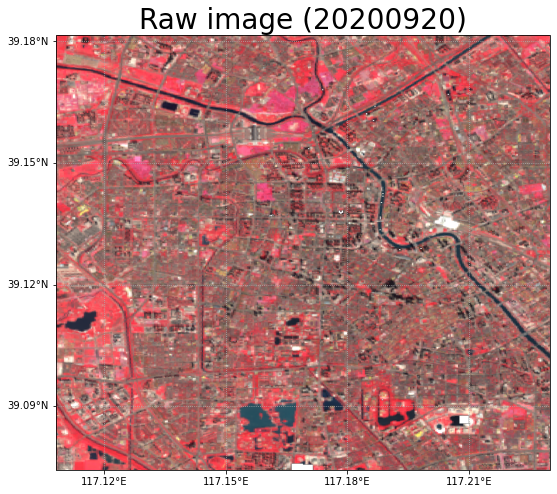

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# 建筑物阴影
# re = [116.7202, 38.7238, 116.8516, 38.8517]
re = [117.2300, 39.0743, 117.1080, 39.1816]

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920'))).clip(roi)
# image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920')).clip(roi)

refer_img = image.visualize(**visParams)
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(refer_img, region=re)
# cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
ax.set_title(label = 'Raw image (20200920)', fontsize=28)

In [16]:
region = 'tianjin'
sample_region = 'TIANJIN'

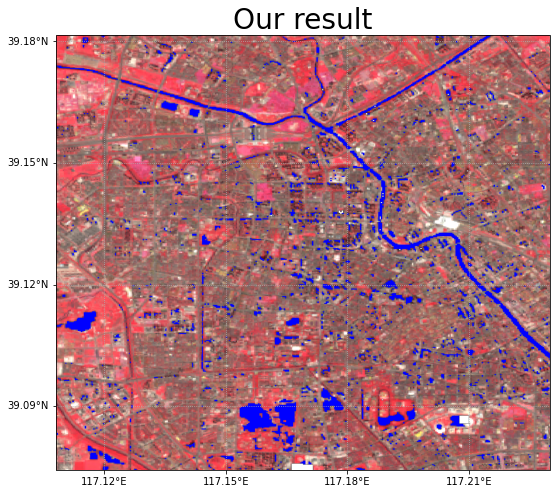

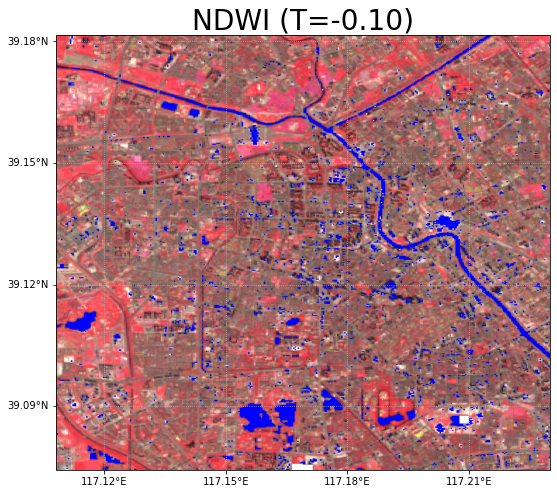

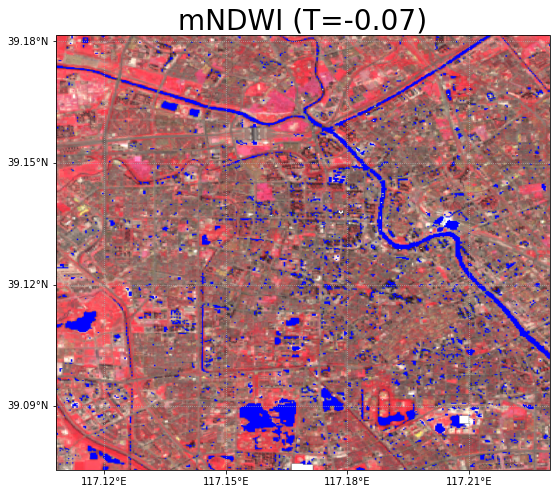

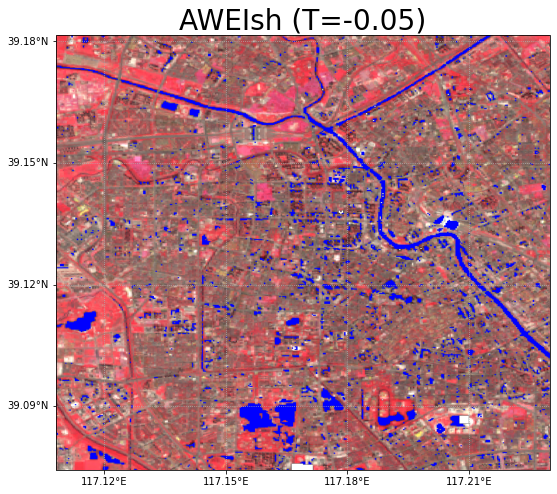

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee


item = [['new_result','Our result'],['ndwi','NDWI (T=-0.10)'],['mndwi','mNDWI (T=-0.07)'],['awei','AWEIsh (T=-0.05)']]
# item = [['new_result','Our result'],['ndwi','NDWI'],['mndwi','mNDWI'],['awei','AWEI']]

# 建筑物阴影
# re = [116.7202, 38.7238, 116.8516, 38.8517]
re = [117.2300, 39.0743, 117.1080, 39.1816]


visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920'))).clip(roi)
# image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123033_20200920')).clip(roi)

for it in item:
    if it[0] == 'new_result':
        totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
        label = 'waterclass'
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
        trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
        classify_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass')  
    elif it[0] == 'ndwi':
        classify_result = image.select('NDWI').gt(-0.10)
    elif it[0] == 'mndwi':
        classify_result = image.select('mNDWI').gt(-0.07058224259853739)
    elif it[0] == 'awei':
        classify_result = image.select('AWEI').gt(-0.05)
    refer_img = image.visualize(**visParams)
    pw = classify_result.selfMask().visualize(**{'palette':['blue']})
    blend = refer_img.blend(pw)
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=re)
    # cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
    cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
    ax.set_title(label = it[1], fontsize=28)

# 制图--1

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee


visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = seasonclass1.selfMask().visualize(**{'palette':['blue']})
blend = refer_img.blend(pw)
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme A'
ax.set_title(label = label, fontsize=28)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = classify_image1.selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['#7960ff']})).blend(classify_image2.selfMask().visualize(**{'palette':['#3fd6c1']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme B vs scheme A'
ax.set_title(label = label, fontsize=28)

In [ ]:
# 有效像元的计算
validPixel1 = landsat_image.map(maskSR).count().select('B3').clip(roi).rename('count')
vis = {'palette': ['ffffff', 'dd09ec'], 'min': 0.0, 'max': 200.0, 'opacity': 1.0}
Map.addLayer(validPixel1,vis,'validPixel1')

waterPixel1 = landsat_image.map(lambda i :maskSR(i).select(bands).classify(trainedClassifier1).eq(1).rename('waterclass')).sum()
Map.addLayer(waterPixel1,{'palette': ['ffffff', 'dd09ec'], 'min': 0.0, 'max': 50.0},'waterPixel1')

waterfrequency1 = waterPixel1.divide(validPixel1).rename('frequency')
Map.addLayer(waterfrequency1,{'palette':['white','green'],'min':0,'max':1},"water frequency1")

# permanentwater = waterfrequency.gte(0.75)
# Map.addLayer(permanentwater.selfMask(),{'palette':['blue']},"permanent water")